<a href="https://colab.research.google.com/github/ToshiroHJJZ/Detection-and-Classification-of-Linguistic-Features-for-Effective-Spam-Identification/blob/main/Adversial_attack_Ham.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os

df = pd.read_csv("/content/drive/MyDrive/HThesis/spam.csv", encoding='latin-1')


In [3]:
#remove the 3 and 4rth column
df = df.drop(df.columns[[2,3,4]], axis=1)
# select only ham part
df=df[df['v1']=='ham']

In [4]:
data= df.rename(columns={'v2': 'text'})

In [5]:
import random
import nltk
from nltk.corpus import wordnet

# Download wordnet for synonym replacement if not already downloaded
nltk.download('wordnet')


ham_df = pd.DataFrame(data)

def get_synonym(word):
    """Get a synonym for a word if available."""
    synonyms = wordnet.synsets(word)
    if synonyms:
        for lemma in synonyms[0].lemmas():
            synonym = lemma.name()
            if synonym.lower() != word.lower():
                return synonym
    return word

def synonym_replacement(text, num_replacements=1):
    """Replace words in the text with synonyms."""
    words = text.split()
    new_words = words[:]
    random_word_list = [word for word in words if wordnet.synsets(word)]
    random.shuffle(random_word_list)

    num_replaced = 0
    for random_word in random_word_list:
        synonym = get_synonym(random_word)
        if synonym != random_word:
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
            if num_replaced >= num_replacements:
                break
    return ' '.join(new_words)

def char_swap(text, num_swaps=1):
    """Randomly swap adjacent characters in the text."""
    text = list(text)
    for _ in range(num_swaps):
        idx = random.randint(0, len(text) - 2)
        text[idx], text[idx + 1] = text[idx + 1], text[idx]
    return ''.join(text)

def random_insertion(text, num_insertions=1):
    """Insert spammy words randomly into the text."""
    spammy_words = ["limited", "urgent", "winner", "click", "offer", "gift",
    "earn", "billion", "cash", "free",  "giveaway", "click link", "limited offer", "flash sale", "exclusive deal",
    "win big", "free gift", "act fast", "claim your prize", "urgent",
    "limited time", "last chance", "click now", "swipe up", "must see",
    "free entry", "special offer", "don’t miss", "win now", "unlock",
    "amazing deal", "get it here", "check this out", "viral",
    "guaranteed winner", "limited spots", "claim free", "join now", "only today",
    "don’t wait", "biggest sale", "double tap", "repost to win", "follow us",
    "secret offer", "instant access", "see details", "claim now", "gift card",
    "link in bio", "only for you", "just for you", "get yours", "cash prize",
    "redeem now", "early access", "exclusive content", "click to learn more",
    "personal message", "free shipping", "limited stock", "real winner",
    "too good to miss", "you’ve been selected", "view profile", "lucky winner"]
    words = text.split()
    for _ in range(num_insertions):
        spam_word = random.choice(spammy_words)
        insert_pos = random.randint(0, len(words))
        words.insert(insert_pos, spam_word)
    return ' '.join(words)

def apply_adversarial_attack(text):
    """Apply a combination of adversarial attacks to the text."""
    text = synonym_replacement(text, num_replacements=1)
    text = char_swap(text, num_swaps=1)
    text = random_insertion(text, num_insertions=1)
    return text

# Create a new DataFrame with attacked versions of the ham messages
attacked_data = []

for index, row in ham_df.iterrows():
    # Assuming the column containing the message is named 'message' instead of 'v2'
    original_message = row["text"]

    # Append the original message with non-attacked label
    # Changed from: attacked_data.append({"text": original_message, "text": 0})
    attacked_data.append({"text": original_message, "label": 0})  # Correctly assign label

    # Create an attacked version of the message and add to the data
    attacked_message = apply_adversarial_attack(original_message)

    # Append attacked message with attacked label
    attacked_data.append({"text": attacked_message, "label": 1})

# Convert to DataFrame
attacked_df = pd.DataFrame(attacked_data)

# Display the new DataFrame
print(attacked_df)

# optionally save the datset to csv
location = "/content/drive/MyDrive/HThesis/"

attacked_df.to_csv("ham_attacked_non_attacked.csv", index=False)

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                                   text  label
0     Go until jurong point, crazy.. Available only ...      0
1     Go until jurong point, crazy.. Available only ...      1
2                         Ok lar... Joking wif u oni...      0
3            Oklahoma lar... Joking wif u oni... unlock      1
4     U dun say so early hor... U c already then say...      0
...                                                 ...    ...
9645  Pity, * Wahsington in mood for urgent that. So...      1
9646  The guy did some bitching but I acted like i'd...      0
9647  The guy did some bitching but I acted like i'd...      1
9648                         Rofl. Its true to its name      0
9649  Rofl. free entry information_technology true t...      1

[9650 rows x 2 columns]


In [6]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score

# Load the dataset (assuming you've saved it as 'ham_attacked_non_attacked.csv')
data = pd.read_csv("/content/drive/MyDrive/HThesis/ham_attacked_non_attacked.csv")



data.head()


,text,label
0,"Go until jurong point, crazy.. Available only ...",0
1,"Go until jurong point, crazy.. Available earn ...",1
2,Ok lar... Joking wif u oni...,0
3,Ok lar... joke wif urgent u oni...,1
4,Free entry in 2 a wkly comp to win FA Cup fina...,0


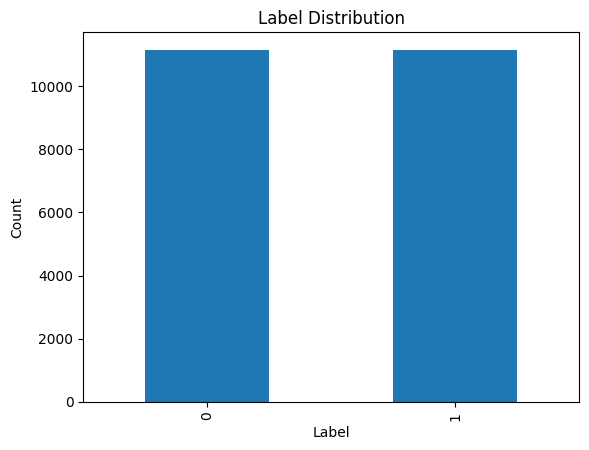

In [7]:
data['label'].value_counts().plot(kind='bar')
# rename 0 to ham 1 is adversial spam
plt.title('Label Distribution')
plt.xlabel('Label')
plt.ylabel('Count')
plt.show()

In [8]:
# word cloud on text
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5), facecolor=None)



<Figure size 1000x500 with 0 Axes>

<Figure size 1000x500 with 0 Axes>

In [9]:
# split the data two part label is 0 and 1
ham_df = data[data['label'] == 0]
spam_df = data[data['label'] == 1]

In [10]:
# word cloud on text
from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(" ".join(ham_df['text']))

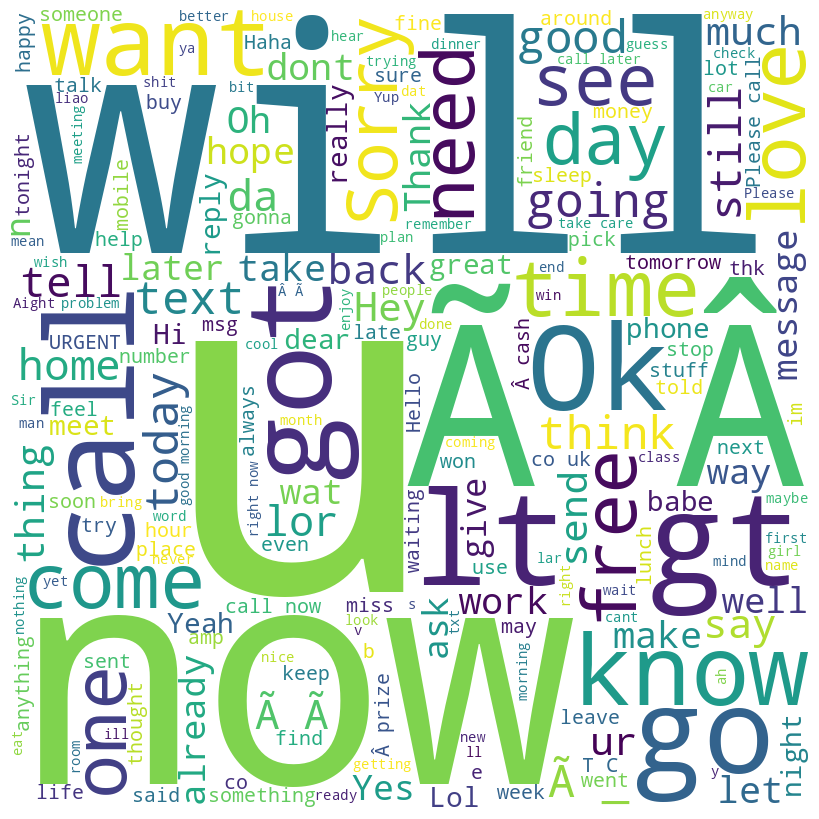

In [11]:
# plot the word cloud #we are not using word cloud for this EDA, since it is useless.
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [12]:
# word cloud on text
from wordcloud import WordCloud
wordcloud = WordCloud(width = 800, height = 800,
                background_color ='white',
                min_font_size = 10).generate(" ".join(spam_df['text']))

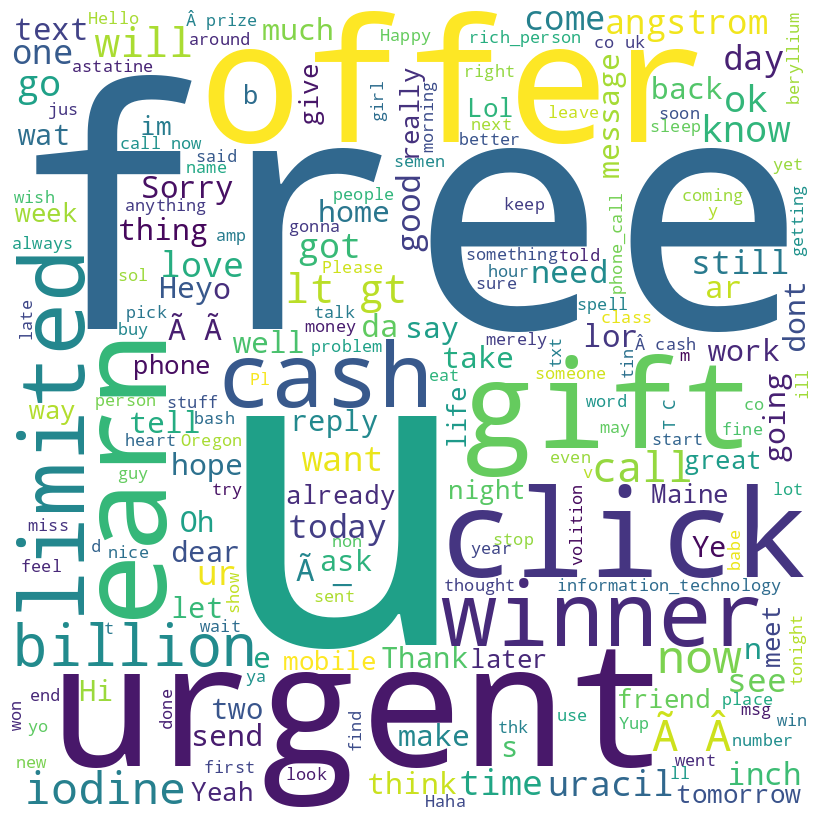

In [13]:
# plot the word cloud #we are not using word cloud for this EDA, since it is useless.
plt.figure(figsize = (8, 8), facecolor = None)
plt.imshow(wordcloud)
plt.axis("off")
plt.tight_layout(pad = 0)
plt.show()

In [14]:
# Step 1: Preprocess the text data with TF-IDF
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['text']).toarray()
y = data['label']

In [15]:
# Step 2: Train-test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)



Multiple models

In [16]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, accuracy_score
import joblib

In [1]:
# Define models
models = {
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Logistic Regression': LogisticRegression(max_iter=10000),
    'Decision Tree': DecisionTreeClassifier(),
    'Random Forest': RandomForestClassifier(),
    'Support Vector Machine': SVC(),
    'Bagging Classifier': BaggingClassifier(),
    'Gradient Boosting': GradientBoostingClassifier()
}

#creates a list to store the results
results = []

NameError: name 'KNeighborsClassifier' is not defined

In [ ]:
# Train and evaluate each model
for model_name, model in models.items():
    pipeline = Pipeline([('model', model)]) # Create a pipeline for each model
    pipeline.fit(X_train, y_train)
    y_pred = pipeline.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, output_dict=True)
    results.append([model_name, accuracy, report])

    # Extract metrics for each class and overall
    metrics = []
    for class_name in report.keys():
        if class_name in ['accuracy', 'macro avg', 'weighted avg']:
            continue
        class_metrics = report[class_name]
        class_metrics['class'] = class_name
        class_metrics['model'] = model_name
        metrics.append(class_metrics)

# Add overall accuracy
    metrics.append({'model': model_name, 'class': 'accuracy', 'precision': None,
                    'recall': None, 'f1-score': accuracy, 'support': None})

    results.extend(metrics)  # Extend results list with metrics for this model


 # Save the trained model to a file using joblib
    joblib.dump(pipeline, f'{model_name}.pkl')

In [ ]:
# Create a DataFrame from the results
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Classification Report'])

# Save the results to a CSV file
results_df.to_csv('model_results.csv', index=False)

In [ ]:
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Classification Report', 'r_score'])
# Print the DataFrame
print(results_df)

In [ ]:
results_df = pd.DataFrame(results, columns=['Model', 'Accuracy', 'Classification Report'])
results_df